## 20201127_byc - Retention and survival n BYC 2.02 20201008 mask 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import tkinter as tk
import tkinter.filedialog as tkdia

from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
import seaborn as sns
from read_roi import read_roi_file, read_roi_zip

from lifelines import KaplanMeierFitter
from lifelines import WeibullFitter 
import lifelines.datasets as ld
import scipy.optimize as opt

wbf = WeibullFitter()
kmf = KaplanMeierFitter()

plt.style.use('default')
matplotlib.rcParams['font.sans-serif'] = 'Arial'

In [4]:
import os

In [5]:
from byc import constants, utilities, files, standard_analysis

### Read in data
From 20201127

In [6]:
# Find bud roi dfs and make a master
# index dataframe with them
write = False
compartment_dir = r"C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC189_mScarletI-1013deg"
exptdir = os.path.dirname(compartment_dir)
pattern = constants.patterns.bud_roi_df_file
bud_paths = utilities.get_filepaths_with_pattern(pattern,
                                                 rootdir=exptdir)
bud_roi_dfs = [pd.read_csv(p) for p in bud_paths]

In [7]:
inds = ['xy', 'cell_index']
collection_interval = 10

alldf = pd.concat(bud_roi_dfs, ignore_index=True)
alldf.set_index(inds, inplace=True)
cols_to_add = ['rls',
               'rls_observed',
               'retention_time_hrs',
               'retention_observed']
for col in cols_to_add:
    alldf.loc[:, col] = np.full(len(alldf), np.nan)

mdf_path = r"C:\Users\John Cooper\Projects\byc\data\20201127_byc\20201127_master_index_analysis.csv"
mdf = pd.read_csv(mdf_path)

drops = []
for mindex in alldf.index:
    
    if mindex in mdf.set_index(inds).index:
        crop_roi_df_path = mdf.set_index(inds).loc[mindex, 'crop_roi_set_path']
        
        if os.path.exists(crop_roi_df_path):
            end_event_type = mdf.set_index(inds).loc[mindex, 'end_event_type']
            crop_rois = read_roi_zip(crop_roi_df_path)
            crop_pos_indices = files.read_roi_position_indices(crop_roi_df_path)
            retention_time = crop_pos_indices.max()*collection_interval
            alldf.loc[mindex, 'retention_time_hrs'] = retention_time/60
            
            if crop_pos_indices.min() != 0:
                drops.append(mindex)
            else:
                alldf.loc[mindex, 'end_event_type'] = end_event_type
        else:
            pass
budsdf = alldf.drop(drops)        

From 20200320 when I analyzed effect of escape void width on retention

In [8]:
path = r"C:\Users\John Cooper\Projects\byc\data\20200320_byc\20200320_byc_analysis\Survival_Data_all.csv"
old_budsdf = pd.read_csv(path)

### Process data

In [9]:
for i in budsdf.index:
    cellrow = budsdf.loc[i, :]
    bud_rois_path = cellrow.bud_roi_set_path
    bud_pos_indices = files.read_roi_position_indices(bud_rois_path)
    celldict = {}
    # Set retention and survival quantities
    end_event_type = cellrow.end_event_type
    rls = len(bud_pos_indices)
    retention_time = (bud_pos_indices.max()*collection_interval)/60
    if budsdf.isna().loc[i, 'retention_time_hrs']:
        budsdf.loc[i, 'retention_time_hrs'] = retention_time
    # Add small number to get rid of zeroes in dataset
    budsdf.loc[i, 'retention_time_hrs'] = budsdf.loc[i, 'retention_time_hrs'] + 0.1

    budsdf.loc[i, 'rls'] = rls
    # Add a censor values for survival fitting
    # based on end_event_type which refers to 
    # what happened after the last frame in the
    # crop or bud roi set for this cell
    if end_event_type == 'death':
        budsdf.loc[i, 'rls_observed'] = True
        budsdf.loc[i, 'retention_observed'] = False
    elif end_event_type == 'escape':
        budsdf.loc[i, 'rls_observed'] = False
        budsdf.loc[i, 'retention_observed'] = True
    elif end_event_type == 'sen':
        budsdf.loc[i, 'rls_observed'] = False
        budsdf.loc[i, 'retention_observed'] = False

Process old data from 20200320

In [10]:
for i in old_budsdf.index:
    end_event_type = old_budsdf.loc[i, 'end_event_type']
    old_budsdf.loc[i, 'retention_time_hrs'] = old_budsdf.loc[i, 'roi_timepoint'] + 0.1
    if end_event_type == 'death':
        old_budsdf.loc[i, 'rls_observed'] = True
        old_budsdf.loc[i, 'retention_observed'] = False
    elif end_event_type == 'escape':
        old_budsdf.loc[i, 'rls_observed'] = False
        old_budsdf.loc[i, 'retention_observed'] = True
    elif end_event_type == 'sen':
        old_budsdf.loc[i, 'rls_observed'] = False
        old_budsdf.loc[i, 'retention_observed'] = False

In [11]:
def survival_fit(table, **kwargs):
    T_col = kwargs.get('T_col', 'rls')
    E_col = kwargs.get('E_col', 'observed')
    T = table[T_col]
    E = table[E_col]

    kmf.fit(T, event_observed=E)
    wbf.fit(T, event_observed=E)

    x_kmf = kmf.survival_function_.index
    y_kmf = kmf.survival_function_.values

    x_wbf = np.arange(0, T.max()+1, 1)
    y_wbf = [wbf.survival_function_at_times(x) for x in x_wbf]
    
    keys = ['y_kmf', 'x_kmf', 'x_wbf', 'y_wbf']
    data = [y_kmf, x_kmf, x_wbf, y_wbf]
    
    fit_dict = dict(zip(keys, data))
    
    return fit_dict

In [12]:
void_80_fit = survival_fit(old_budsdf[old_budsdf.escape_void_width == 80],
                           T_col='retention_time_hrs',
                           E_col='retention_observed')
void_65_fit = survival_fit(old_budsdf[old_budsdf.escape_void_width == 65],
                           T_col='retention_time_hrs',
                           E_col='retention_observed')
void_50_fit = survival_fit(old_budsdf[old_budsdf.escape_void_width == 50],
                           T_col='retention_time_hrs',
                           E_col='retention_observed')

C:\.byc\lib\site-packages\lifelines\utils\__init__.py:1176: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
C:\.byc\lib\site-packages\lifelines\utils\__init__.py:1176: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
C:\.byc\lib\site-packages\lifelines\utils\__init__.py:1176: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


In [13]:
fit = survival_fit(budsdf, T_col='rls', E_col='rls_observed')
escape_fit = survival_fit(budsdf, T_col='retention_time_hrs', E_col='retention_observed')

C:\.byc\lib\site-packages\lifelines\utils\__init__.py:1176: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
C:\.byc\lib\site-packages\lifelines\utils\__init__.py:1176: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


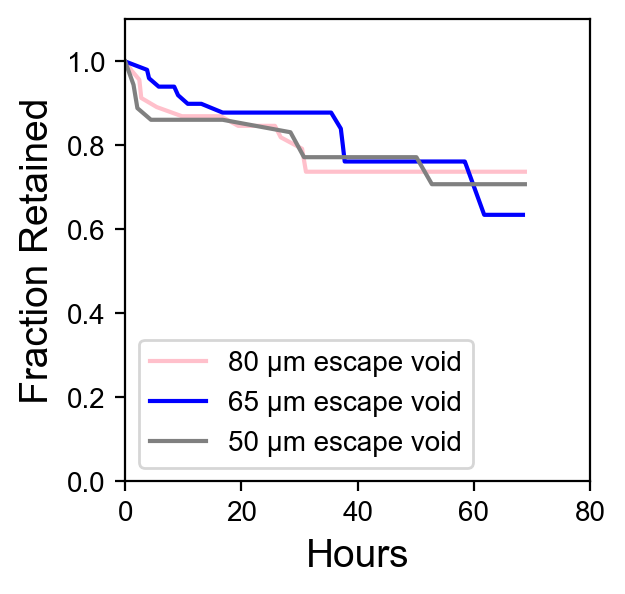

In [15]:
fig = plt.figure(figsize=(3, 3))
fig.set_dpi(200)
ax = plt.axes()

colors = ['pink', 'blue', 'gray']
void_widths =['80', '65', '50']
fit_dicts = [void_80_fit, void_65_fit, void_50_fit]


i = 0
for fit_dict in fit_dicts:
    x_kmf = fit_dict['x_kmf']
    y_kmf = fit_dict['y_kmf']
    ax.plot(x_kmf, y_kmf, color=colors[i])
    i+=1


# Y axis settings
ax.set_ylim(0, 1.1)
ax.set_ylabel('Fraction Retained', fontsize=14)

# X axis settings
ax.set_xlabel('Hours', fontsize=14)
ax.set_xlim(0, 80)

custom_lines = [Line2D([0], [0], color=color, lw=1.5) for color in colors]

custom_titles = [f'{void_width} \u03BCm escape void' for void_width in void_widths]

ax.legend(custom_lines, custom_titles)

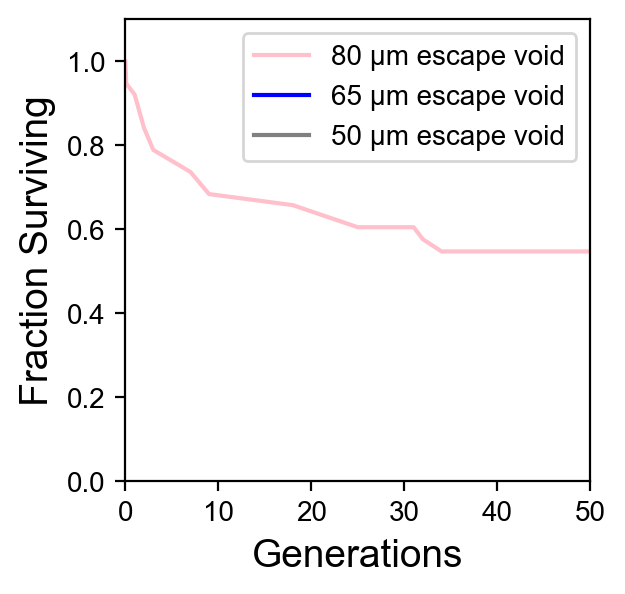

In [203]:
fig = plt.figure(figsize=(3, 3))
fig.set_dpi(200)
ax = plt.axes()

colors = ['pink', 'blue', 'gray']
void_widths =['80', '65', '50']
fit_dicts = [escape_fit]


i = 0
for fit_dict in fit_dicts:
    x_kmf = fit_dict['x_kmf']
    y_kmf = fit_dict['y_kmf']
    ax.plot(x_kmf, y_kmf, color=colors[i])
    i+=1


# Y axis settings
ax.set_ylim(0, 1.1)
ax.set_ylabel('Fraction Surviving', fontsize=14)

# X axis settings
ax.set_xlabel('Generations', fontsize=14)
ax.set_xlim(0, 50)

custom_lines = [Line2D([0], [0], color=color, lw=1.5) for color in colors]

custom_titles = [f'{void_width} \u03BCm escape void' for void_width in void_widths]

ax.legend(custom_lines, custom_titles)